In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_2311/3827359723.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
ds_version = "RTK"
annotations_file = "GT_RTK.csv"
# train and prediction crop: lower_middle_half
pred_file = "V1_0_lmh-crop_trained_prediction-RTK_GT-20240816_113354.csv"
# no cropping
# pred_file = "efficientnet_CC_prediction-RTK_GT-20240808_123946.csv"
# train crop lower_middle_half, prediction crop lower_half_rtk
# pred_file_crop_rtk = "efficientnet_CC_prediction-RTK_GT-20240808_113605.csv"
# train and prediction crop: lower_half_rtk
# pred_file_crop_rtk = "V1_0_rtk-crop_trained_prediction-RTK_GT-20240812_180108.csv"

root_data_path = os.path.join("..", "data", ds_version) # TODO: prediction folder, see prediction file
data_path = os.path.join(root_data_path, "metadata") # TODO: prediction folder, see prediction file

In [5]:
pred = pd.DataFrame()

print(f"reading {pred_file}")
pred = pd.read_csv(os.path.join(data_path, pred_file))
pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred", "Level_1": "quality_pred"}, inplace=True)

quality_pred = pred[pred.Level == "quality"][["image_id", "Prediction", "quality_pred", "is_in_validation"]]
quality_pred.rename(columns={"Prediction": "quality_float_pred"}, inplace=True)

type_pred = pred[pred.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
idx = type_pred.groupby("image_id")["class_prob"].idxmax()
type_pred = type_pred.loc[idx]
pred = quality_pred.set_index("image_id").join(type_pred.set_index("image_id"), lsuffix="_quality", rsuffix="_type")

# pred_crop = pd.DataFrame()

# print(f"reading {pred_file_crop_rtk}")
# pred_crop = pd.read_csv(os.path.join(data_path, pred_file_crop_rtk))
# pred_crop.rename(columns={"Image": "image_id",  "Level_0": "type_pred", "Level_1": "quality_pred"}, inplace=True)

# quality_pred_crop = pred_crop[pred_crop.Level == "quality"][["image_id", "Prediction", "quality_pred", "is_in_validation"]]
# quality_pred_crop.rename(columns={"Prediction": "quality_float_pred"}, inplace=True)

# type_pred_crop = pred_crop[pred_crop.Level == "type"][["image_id", "Prediction", "type_pred", "is_in_validation"]]
# type_pred_crop.rename(columns={"Prediction": "class_prob"}, inplace=True)
# idx = type_pred_crop.groupby("image_id")["class_prob"].idxmax()
# type_pred_crop = type_pred_crop.loc[idx]
# pred_crop = quality_pred_crop.set_index("image_id").join(type_pred_crop.set_index("image_id"), lsuffix="_quality", rsuffix="_type")

reading V1_0_lmh-crop_trained_prediction-RTK_GT-20240816_113354.csv


In [6]:
pred

,quality_float_pred,quality_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type
image_id,,,,,,
3_000000000,1.889853,good,0,0.966372,asphalt,0
3_000000001,1.571592,good,0,0.983876,asphalt,0
3_000000002,1.882352,good,0,0.982009,asphalt,0
3_000000003,1.466351,excellent,0,0.971124,asphalt,0
3_000000004,1.541530,good,0,0.977404,asphalt,0
...,...,...,...,...,...,...
7_000000791,2.853730,intermediate,0,0.911773,unpaved,0
7_000000792,3.128268,intermediate,0,0.927196,unpaved,0
7_000000793,2.736801,intermediate,0,0.885463,unpaved,0


In [7]:
# pred_crop

In [8]:
annot = pd.read_csv(os.path.join(data_path, annotations_file))
annot["quality_float_true"] = annot["quality_true"].map({"good": 2, "regular": 3, "bad": 4,})

In [9]:
annot

,image_id,type_true,quality_true,quality_float_true
0,3_000000000,asphalt,bad,4
1,3_000000001,asphalt,bad,4
2,3_000000002,asphalt,bad,4
3,3_000000003,asphalt,bad,4
4,3_000000004,asphalt,bad,4
...,...,...,...,...
6292,7_000000791,unpaved,regular,3
6293,7_000000792,unpaved,regular,3
6294,7_000000793,unpaved,regular,3
6295,7_000000794,unpaved,regular,3


In [10]:
df = pred.join(
    annot[["image_id", "type_true", "quality_true", "quality_float_true"]].set_index("image_id"), how="left")

In [11]:
# df_crop = pred_crop.join(
#     annot[["image_id", "type_true", "quality_true", "quality_float_true"]].set_index("image_id"), how="left")

In [12]:
df

,quality_float_pred,quality_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type,type_true,quality_true,quality_float_true
image_id,,,,,,,,,
3_000000000,1.889853,good,0,0.966372,asphalt,0,asphalt,bad,4
3_000000001,1.571592,good,0,0.983876,asphalt,0,asphalt,bad,4
3_000000002,1.882352,good,0,0.982009,asphalt,0,asphalt,bad,4
3_000000003,1.466351,excellent,0,0.971124,asphalt,0,asphalt,bad,4
3_000000004,1.541530,good,0,0.977404,asphalt,0,asphalt,bad,4
...,...,...,...,...,...,...,...,...,...
7_000000791,2.853730,intermediate,0,0.911773,unpaved,0,unpaved,regular,3
7_000000792,3.128268,intermediate,0,0.927196,unpaved,0,unpaved,regular,3
7_000000793,2.736801,intermediate,0,0.885463,unpaved,0,unpaved,regular,3


In [13]:
df.groupby(["type_true", "quality_true"]).size()

type_true  quality_true
asphalt    bad              464
           good            1978
           regular          839
paved      bad              124
           good            1179
           regular          324
unpaved    bad              593
           regular          796
dtype: int64

In [14]:
df.shape

(6297, 9)

## Global measures

In [13]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float),
    "mae": mean_absolute_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

#### global measures for type

In [14]:
# all
gm = compute_measures_cat(df.type_true, df.type_pred)
gm_valid = compute_measures_cat(df_valid_type.type_true, df_valid_type.type_pred)
gm_train = compute_measures_cat(df_train_type.type_true, df_train_type.type_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train")], axis=1).round(2)

NameError: name 'df_valid_type' is not defined

In [22]:
# all
gm = compute_measures_cat(df_test.type_true, df_test.type_pred)
pd.concat([pd.Series(gm, name="all test")], axis=1).round(2)

,all test
accuracy,0.91


#### global measures for quality

In [14]:
# all
gm = compute_measures_float(df.quality_float_true, df.quality_float_pred)
gm_valid = compute_measures_float(df_valid_quality.quality_float_true, df_valid_quality.quality_float_pred)
gm_train = compute_measures_float(df_train_quality.quality_float_true, df_train_quality.quality_float_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train")], axis=1).round(3)

,all,validation,train
accuracy,0.859,0.630,0.915
correlation,0.946,0.860,0.966
r_square,0.879,0.726,0.917
mse,0.133,0.305,0.091
mae,0.271,0.439,0.230
rmse,0.364,0.552,0.301


In [21]:
# all
gm = compute_measures_float(df_test.quality_float_true, df_test.quality_float_pred)
pd.concat([pd.Series(gm, name="all test")], axis=1).round(3)

,all test
accuracy,0.611
correlation,0.801
r_square,0.635
mse,0.344
mae,0.461
rmse,0.586


## Surface type

In [16]:
#plt.rcParams.update({'font.size': 14})

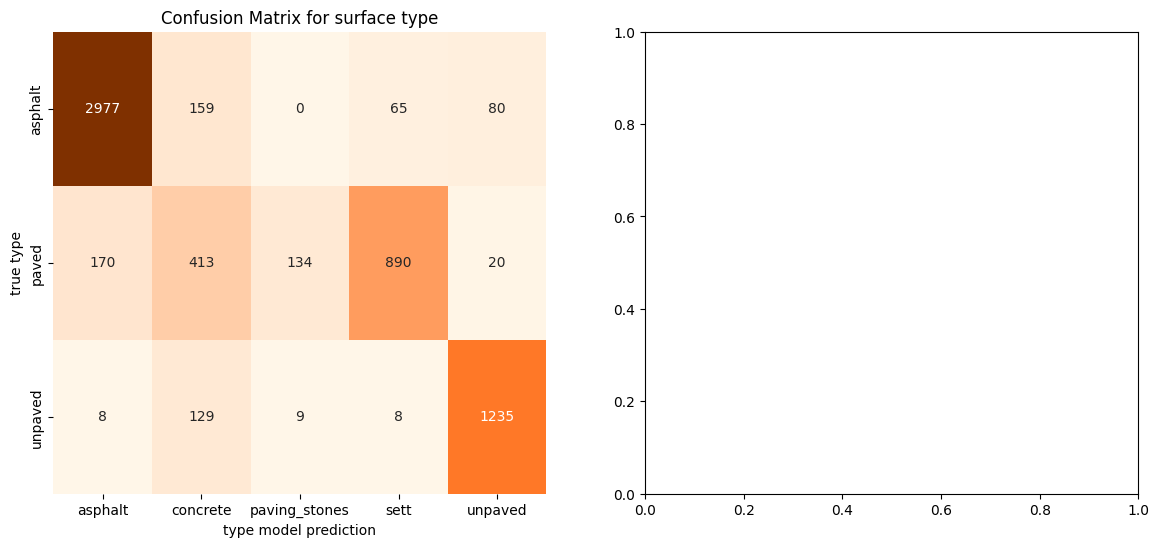

In [20]:
# confusion matrix for all model surface types
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

# labels_type_true = df.type_true.unique()
# labels_type_pred = df.type_pred.unique()
labels = ['asphalt', 'concrete', 'paving_stones', 'sett', 'paved', 'unpaved']

# cm = confusion_matrix(df[~((df.type_true == "paved") & (df.quality_true == "good"))].type_true, df[~((df.type_true == "paved") & (df.quality_true == "good"))].type_pred, labels=labels)
cm = confusion_matrix(df.type_true, df.type_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['asphalt', 'concrete', 'paving_stones', 'sett', 'unpaved']]
cm_df = cm_df.loc[['asphalt', 'paved', 'unpaved']]
# plt.figure()
# sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
#             xticklabels=['asphalt', 'concrete', 'paving_stones', 'sett', 'unpaved'],
#             yticklabels=['asphalt', 'paved', 'unpaved'])
# plt.title(f"Confusion Matrix for surface type")
# plt.xlabel("type model prediction")
# plt.ylabel("true type")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix für Surface Type
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['asphalt', 'concrete', 'paving_stones', 'sett', 'unpaved'],
            yticklabels=['asphalt', 'paved', 'unpaved'],
            ax=axes[0])
axes[0].set_title(f"Confusion Matrix for surface type")
axes[0].set_xlabel("type model prediction")
axes[0].set_ylabel("true type")

# cm_crop = confusion_matrix(df_crop.type_true, df_crop.type_pred, labels=labels)
# cm_df_crop = pd.DataFrame(cm_crop, index=labels, columns=labels)
# cm_df_crop = cm_df_crop[['asphalt', 'concrete', 'paving_stones', 'sett', 'unpaved']]
# cm_df_crop = cm_df_crop.loc[['asphalt', 'paved', 'unpaved']]

# # Confusion Matrix für Quality
# sns.heatmap(cm_df_crop, annot=True, fmt="d", cmap=cmap, cbar=False,
#             xticklabels=['asphalt', 'concrete', 'paving_stones', 'sett', 'unpaved'],
#             yticklabels=['asphalt', 'paved', 'unpaved'],
#             ax=axes[1])
# axes[1].set_title(f"Confusion Matrix for surface type (RTK crop)")
# axes[1].set_xlabel("type model prediction")
# axes[1].set_ylabel("true type")

# plt.savefig("confusion_matrix_type_RTK.png", transparent=True, bbox_inches='tight')
plt.show()

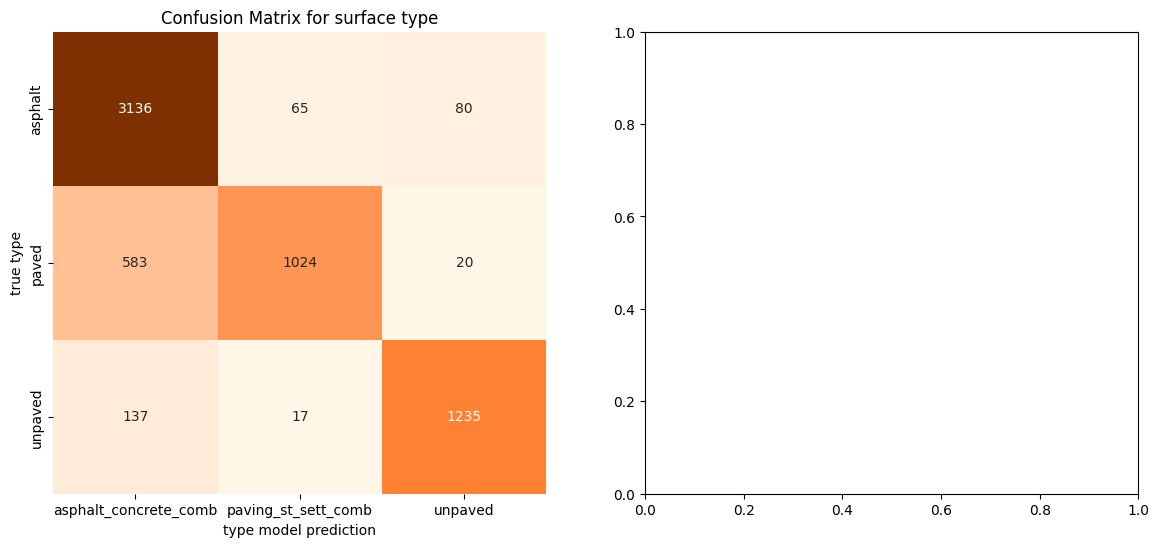

In [21]:
# confusion matrix for combined surface types
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm_df['asphalt_concrete_comb'] = cm_df['asphalt'] + cm_df['concrete']
cm_df['paving_st_sett_comb'] = cm_df['paving_stones'] + cm_df['sett']
cm_df = cm_df[['asphalt_concrete_comb', 'paving_st_sett_comb', 'unpaved']]
# plt.figure()
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['asphalt_concrete_comb', 'paving_st_sett_comb', 'unpaved'],
            yticklabels=['asphalt', 'paved', 'unpaved'],
            ax=axes[0])
axes[0].set_title(f"Confusion Matrix for surface type")
axes[0].set_xlabel("type model prediction")
axes[0].set_ylabel("true type")

# cm_df_crop['asphalt_concrete_comb'] = cm_df_crop['asphalt'] + cm_df_crop['concrete']
# cm_df_crop['paving_st_sett_comb'] = cm_df_crop['paving_stones'] + cm_df_crop['sett']
# cm_df_crop = cm_df_crop[['asphalt_concrete_comb', 'paving_st_sett_comb', 'unpaved']]
# # plt.figure()
# sns.heatmap(cm_df_crop, annot=True, fmt="d", cmap=cmap, cbar=False,
#             xticklabels=['asphalt_concrete_comb', 'paving_st_sett_comb', 'unpaved'],
#             yticklabels=['asphalt', 'paved', 'unpaved'],
#             ax=axes[1])
# axes[1].set_title(f"Confusion Matrix for surface type (RTK crop)")
# axes[1].set_xlabel("type model prediction")
# axes[1].set_ylabel("true type")
# plt.savefig("confusion_matrix_type_RTK.png", transparent=True, bbox_inches='tight')
plt.show()

In [22]:
overall_accuracy = cm_df.values.trace() / cm_df.values.sum()

class_precision = cm_df.rename(columns={'asphalt_concrete_comb': 'asphalt', 'paving_st_sett_comb': 'paved'}).apply(lambda x: x[x.name] / x.sum(), axis=1)

print("Recall per class:")
print(class_precision)

print(f"\nAccuracy: {overall_accuracy:.2f}")


Recall per class:
asphalt    0.955806
paved      0.629379
unpaved    0.889129
dtype: float64

Accuracy: 0.86


In [18]:
overall_accuracy = cm_df_crop.values.trace() / cm_df_crop.values.sum()

class_precision = cm_df_crop.rename(columns={'asphalt_concrete_comb': 'asphalt', 'paving_st_sett_comb': 'paved'}).apply(lambda x: x[x.name] / x.sum(), axis=1)

print("Recall per class:")
print(class_precision)

print(f"\nAccuracy: {overall_accuracy:.2f}")

Recall per class:
asphalt    0.946358
paved      0.839286
unpaved    0.584593
dtype: float64

Accuracy: 0.84


## Surface Quality

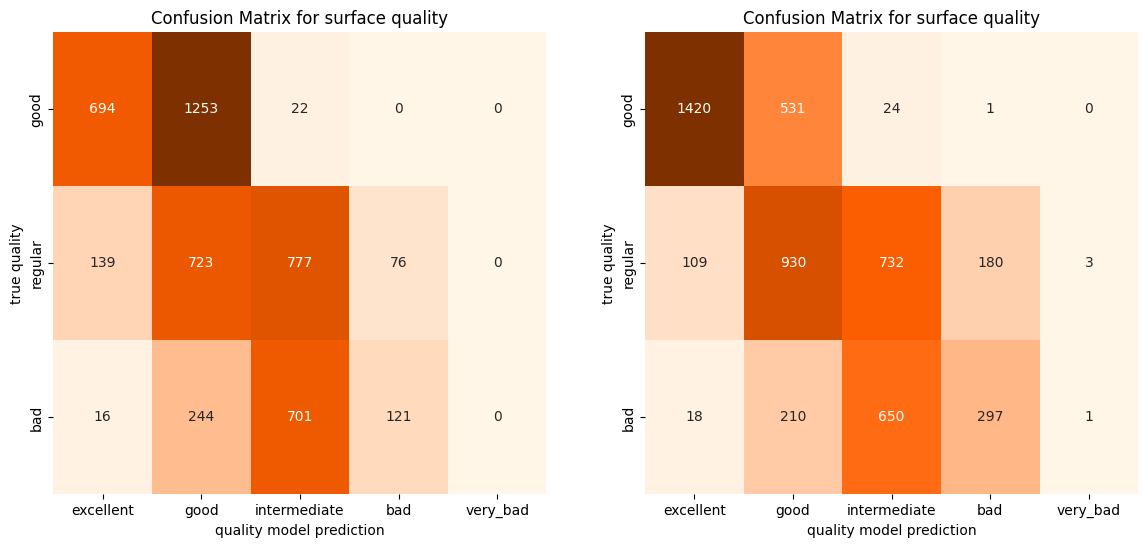

In [19]:
# confusion matrix for all model surface types
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

# labels_type_true = df.type_true.unique()
# labels_type_pred = df.type_pred.unique()
labels = ['excellent', 'good', 'intermediate', 'regular', 'bad', 'very_bad']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm = confusion_matrix(df.quality_true, df.quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df.loc[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            yticklabels=['good', 'regular', 'bad'],
            ax=axes[0])
axes[0].set_title(f"Confusion Matrix for surface quality")
axes[0].set_xlabel("quality model prediction")
axes[0].set_ylabel("true quality")

cm = confusion_matrix(df_crop.quality_true, df_crop.quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df.loc[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            yticklabels=['good', 'regular', 'bad'],
            ax=axes[1])
axes[1].set_title(f"Confusion Matrix for surface quality")
axes[1].set_xlabel("quality model prediction")
axes[1].set_ylabel("true quality")
plt.savefig("confusion_matrix_quality_RTK.png", transparent=True, bbox_inches='tight')
plt.show()

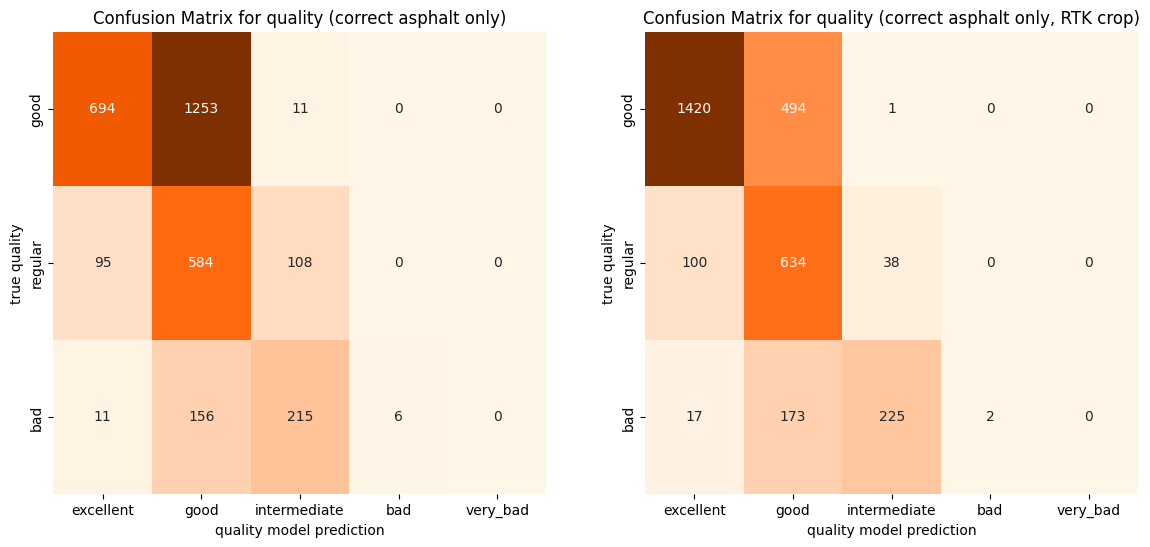

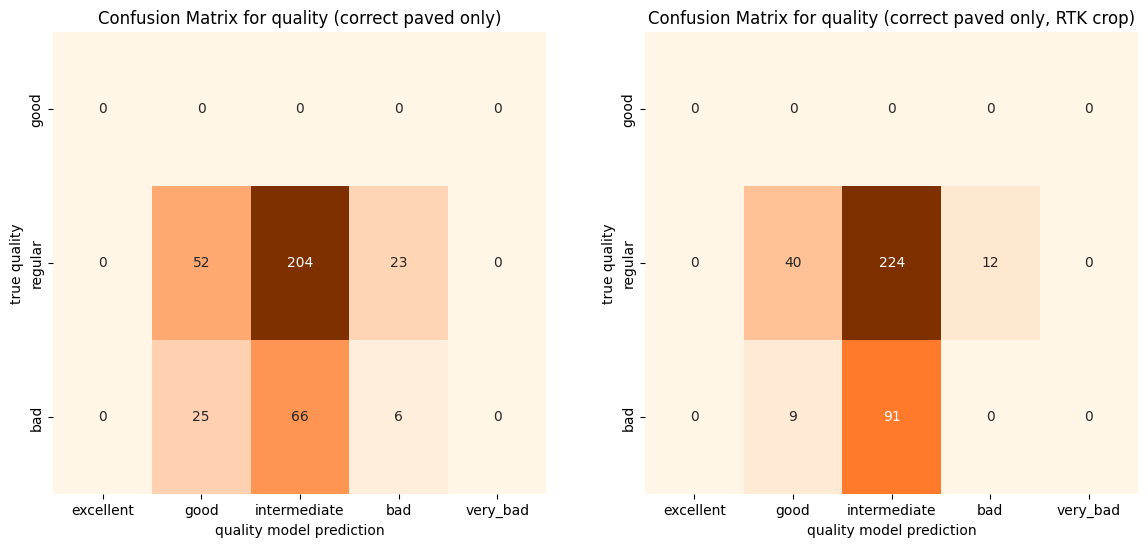

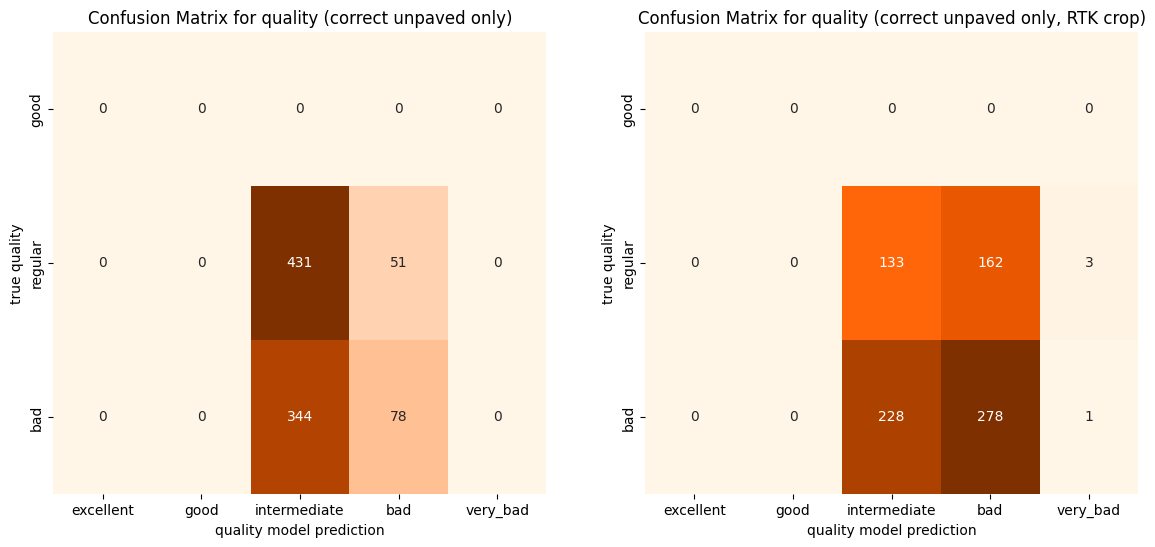

In [20]:
# confusion matrix for all model surface types
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

# labels_type_true = df.type_true.unique()
# labels_type_pred = df.type_pred.unique()
labels = ['excellent', 'good', 'intermediate', 'regular', 'bad', 'very_bad']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm = confusion_matrix(df[(df.type_true == 'asphalt') & (df.type_pred.isin(['asphalt', 'concrete']))].quality_true, df[(df.type_true == 'asphalt') & (df.type_pred.isin(['asphalt', 'concrete']))].quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df.loc[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            yticklabels=['good', 'regular', 'bad'],
            ax=axes[0])
axes[0].set_title(f"Confusion Matrix for quality (correct asphalt only)")
axes[0].set_xlabel("quality model prediction")
axes[0].set_ylabel("true quality")

cm = confusion_matrix(df_crop[(df_crop.type_true == 'asphalt') & (df_crop.type_pred.isin(['asphalt', 'concrete']))].quality_true, df_crop[(df_crop.type_true == 'asphalt') & (df_crop.type_pred.isin(['asphalt', 'concrete']))].quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df.loc[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            yticklabels=['good', 'regular', 'bad'],
            ax=axes[1])
axes[1].set_title(f"Confusion Matrix for quality (correct asphalt only, RTK crop)")
axes[1].set_xlabel("quality model prediction")
axes[1].set_ylabel("true quality")
plt.savefig("confusion_matrix_quality_RTK.png", transparent=True, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm = confusion_matrix(df[(df.type_true == 'paved') & (df.type_pred.isin(['paving_stones', 'sett']))].quality_true, df[(df.type_true == 'paved') & (df.type_pred.isin(['paving_stones', 'sett']))].quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df.loc[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            yticklabels=['good', 'regular', 'bad'],
            ax=axes[0])
axes[0].set_title(f"Confusion Matrix for quality (correct paved only)")
axes[0].set_xlabel("quality model prediction")
axes[0].set_ylabel("true quality")

cm = confusion_matrix(df_crop[(df_crop.type_true == 'paved') & (df_crop.type_pred.isin(['paving_stones', 'sett']))].quality_true, df_crop[(df_crop.type_true == 'paved') & (df_crop.type_pred.isin(['paving_stones', 'sett']))].quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df.loc[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            yticklabels=['good', 'regular', 'bad'],
            ax=axes[1])
axes[1].set_title(f"Confusion Matrix for quality (correct paved only, RTK crop)")
axes[1].set_xlabel("quality model prediction")
axes[1].set_ylabel("true quality")
plt.savefig("confusion_matrix_quality_RTK.png", transparent=True, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm = confusion_matrix(df[(df.type_true == 'unpaved') & (df.type_pred == 'unpaved')].quality_true, df[(df.type_true == 'unpaved') & (df.type_pred == 'unpaved')].quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df.loc[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            yticklabels=['good', 'regular', 'bad'],
            ax=axes[0])
axes[0].set_title(f"Confusion Matrix for quality (correct unpaved only)")
axes[0].set_xlabel("quality model prediction")
axes[0].set_ylabel("true quality")

cm = confusion_matrix(df_crop[(df_crop.type_true == 'unpaved') & (df_crop.type_pred == 'unpaved')].quality_true, df_crop[(df_crop.type_true == 'unpaved') & (df_crop.type_pred == 'unpaved')].quality_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df = cm_df[['excellent', 'good', 'intermediate', 'bad', 'very_bad']]
cm_df = cm_df.loc[['good', 'regular', 'bad']]
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['excellent', 'good', 'intermediate', 'bad', 'very_bad'],
            yticklabels=['good', 'regular', 'bad'],
            ax=axes[1])
axes[1].set_title(f"Confusion Matrix for quality (correct unpaved only, RTK crop)")
axes[1].set_xlabel("quality model prediction")
axes[1].set_ylabel("true quality")
plt.savefig("confusion_matrix_quality_RTK.png", transparent=True, bbox_inches='tight')
plt.show()

In [23]:
df

,quality_float_pred,quality_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type,type_true,quality_true
image_id,,,,,,,,
3_000000000,1.565969,good,0,0.993179,asphalt,0,asphalt,bad
3_000000001,1.398089,excellent,0,0.973016,asphalt,0,asphalt,bad
3_000000002,1.590213,good,0,0.926052,asphalt,0,asphalt,bad
3_000000003,1.437018,excellent,0,0.968208,asphalt,0,asphalt,bad
3_000000004,1.569699,good,0,0.975363,asphalt,0,asphalt,bad
...,...,...,...,...,...,...,...,...
7_000000791,2.223832,outside,0,0.796954,unpaved,0,unpaved,regular
7_000000792,3.074124,intermediate,0,0.933891,unpaved,0,unpaved,regular
7_000000793,1.768394,outside,0,0.946814,unpaved,0,unpaved,regular


In [34]:
import numpy as np
np.corrcoef(df.quality_float_true, df.quality_float_pred)


array([[1.        , 0.64972127],
       [0.64972127, 1.        ]])

In [35]:
print(np.corrcoef(df[df.type_true == "asphalt"].quality_float_true, df[df.type_true == "asphalt"].quality_float_pred))
print(np.corrcoef(df[df.type_true == "paved"].quality_float_true, df[df.type_true == "paved"].quality_float_pred))
print(np.corrcoef(df[df.type_true == "unpaved"].quality_float_true, df[df.type_true == "unpaved"].quality_float_pred))

[[1.         0.66440743]
 [0.66440743 1.        ]]
[[ 1.        -0.1656714]
 [-0.1656714  1.       ]]
[[1.         0.22501999]
 [0.22501999 1.        ]]


## Measures for quality by surface type

In [74]:
gm_surface = pd.DataFrame()
for surface in df_valid_quality.type_true.unique():
    df_ = df_valid_quality[df_valid_quality.type_true == surface]
    gm = compute_measures_float(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,asphalt,concrete,paving_stones,sett,unpaved
accuracy,0.59,0.66,0.63,0.74,0.59
correlation,0.77,0.80,0.71,0.70,0.73
r_square,0.58,0.62,0.48,0.39,0.45
mse,0.32,0.32,0.29,0.24,0.35
rmse,0.57,0.57,0.54,0.49,0.59


## compare float values

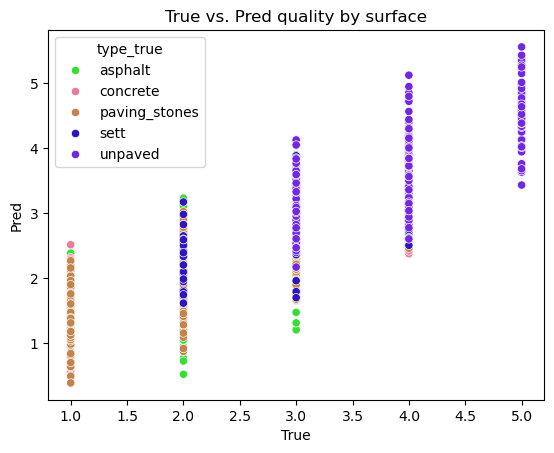

In [75]:
# Plot
np.random.seed(5)
colors = {surface_type: np.random.rand(3,) for surface_type in df_valid_quality.type_true.unique()}

sns.scatterplot(data=df_valid_quality, x="quality_float_true", y="quality_float_pred", hue="type_true", palette=colors, legend="full")
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('True vs. Pred quality by surface')
plt.show()


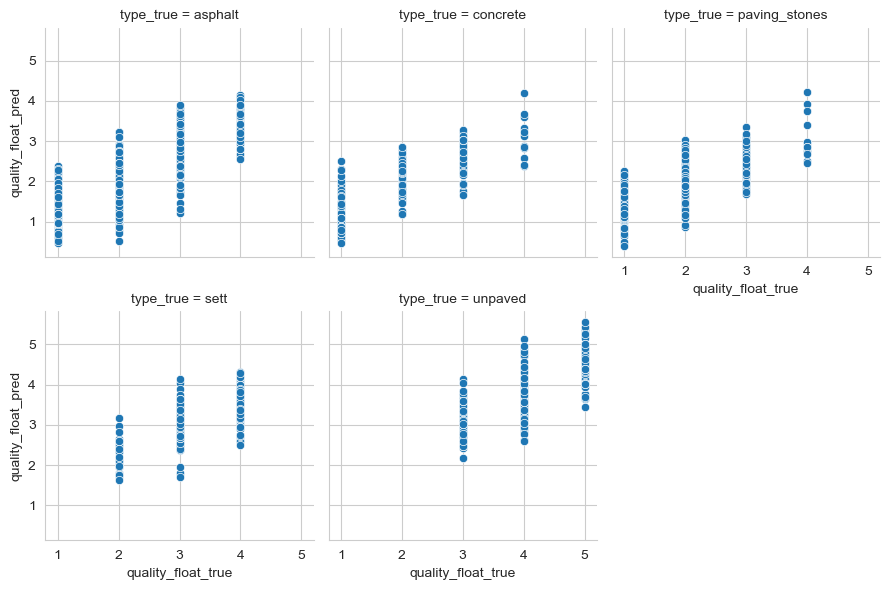

In [76]:
sns.set_style("whitegrid")

# Create a FacetGrid
g = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map scatter plot for each surface type
g.map(sns.scatterplot, "quality_float_true", "quality_float_pred")

plt.show()

#### Hom much do the deviate?

In [80]:
df_valid_quality.loc[:,"deviation"] = df_valid_quality.quality_float_true - df_valid_quality.quality_float_pred

**Overall**

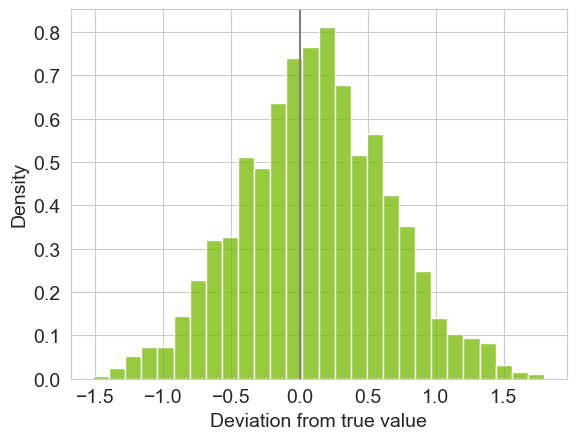

In [182]:
sns.histplot(df_valid_quality, color='#76B900', stat="density", x="deviation")
plt.xlabel("Deviation from true value")
plt.axvline(x=0, color="grey")
plt.savefig("deviation_hist_quality_V1_0.png", transparent=True)
plt.show()


In [160]:
np.mean(df_valid_quality.deviation)

0.1149677615464645

In [158]:
np.std(df_valid_quality.deviation)


0.5403729757753959

In [171]:
(abs(df_valid_quality.deviation) >= 1).value_counts()

deviation
False    1515
True      120
Name: count, dtype: int64

In [173]:
120/len(df_valid_quality)

0.07339449541284404

**by surface**

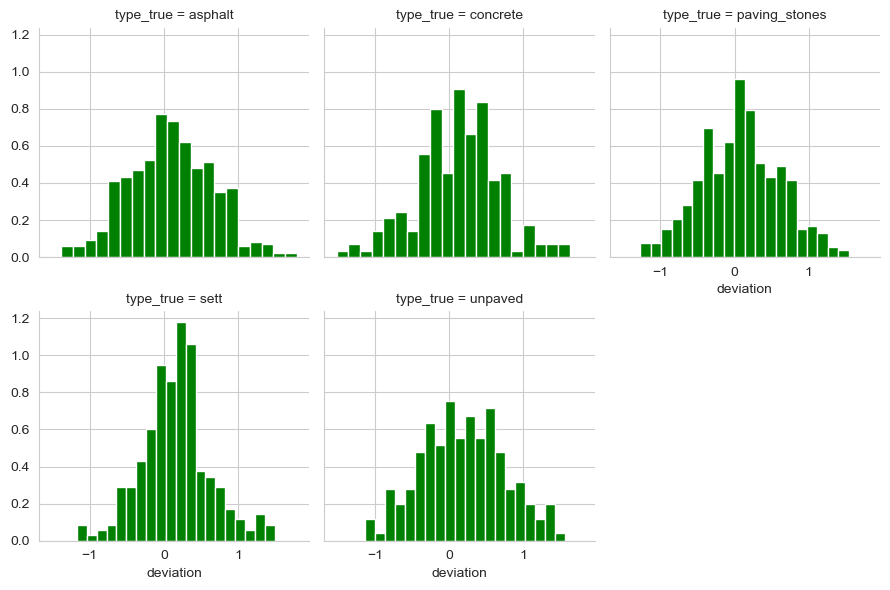

In [82]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map histogram for deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

## compare classes

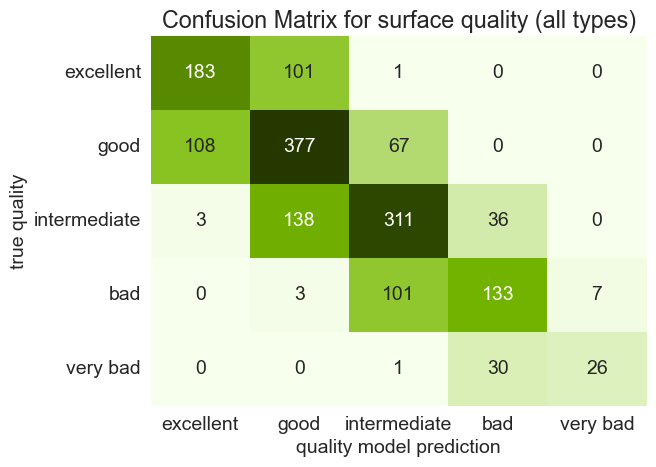

In [185]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_valid_quality.quality_true, df_valid_quality.quality_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very bad"])
plt.title(f"Confusion Matrix for surface quality (all types)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

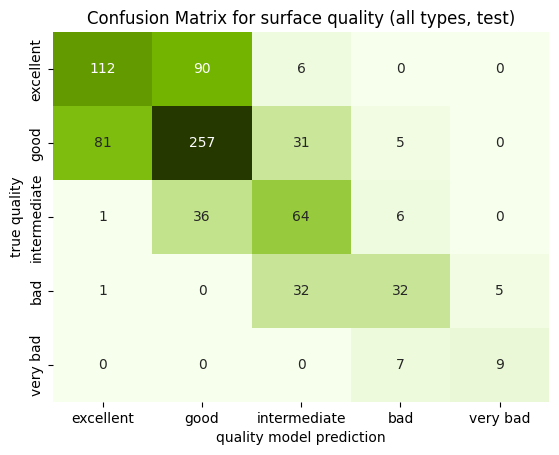

In [23]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_test.quality_true, df_test.quality_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very bad"])
plt.title(f"Confusion Matrix for surface quality (all types, test)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0_test.png", transparent=True, bbox_inches='tight')
plt.show()

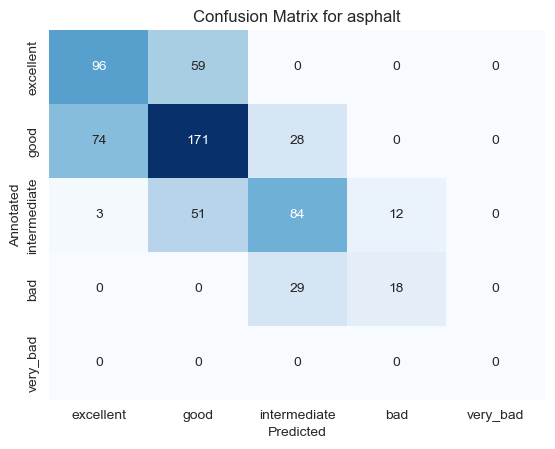

<Figure size 640x480 with 0 Axes>

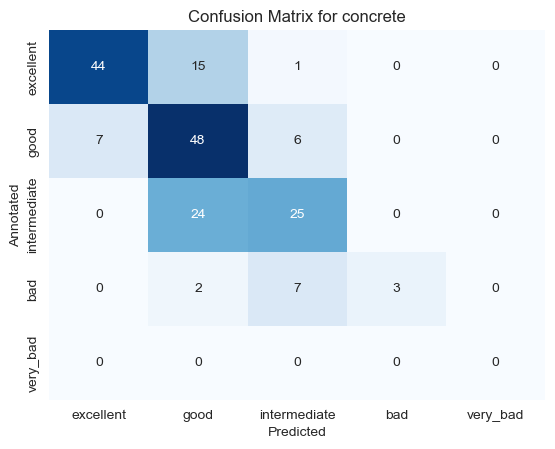

<Figure size 640x480 with 0 Axes>

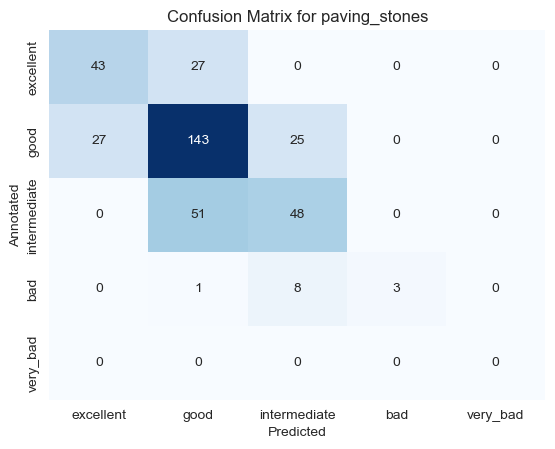

<Figure size 640x480 with 0 Axes>

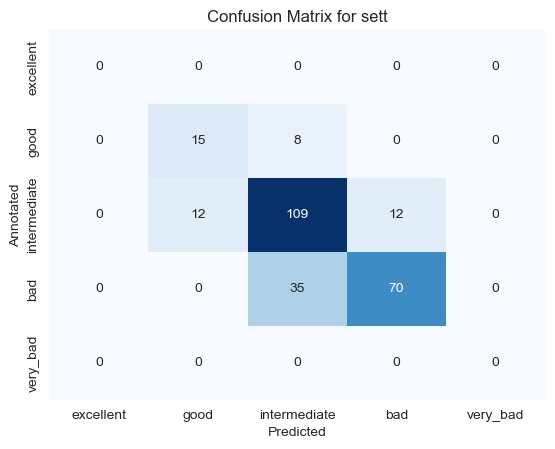

<Figure size 640x480 with 0 Axes>

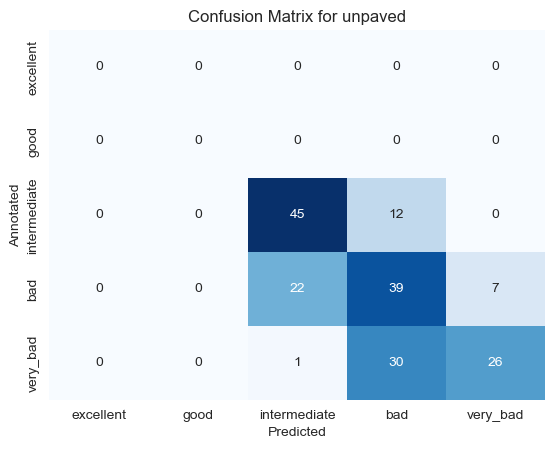

<Figure size 640x480 with 0 Axes>

In [104]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
for surface in df_valid_quality.type_true.unique():
    _df = df_valid_quality[(df_valid_quality.type_true == surface)]
    cm = confusion_matrix(_df.quality_true, _df.quality_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["excellent", "good", "intermediate", "bad", "very_bad"],
                yticklabels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.title(f"Confusion Matrix for {surface}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()



In [99]:
# Extract predicted and ground truth values
precisions = []
recalls = []
f1scores = []
for class_name in df_valid_type['type_true'].unique():
    _df1 = df_valid_type[df_valid_type['type_pred'] == class_name]
    _df2 = df_valid_type[df_valid_type['type_true'] == class_name]
    class_precision = sum(_df1.type_true == class_name) / len(_df1)
    class_recall = sum(_df2.type_pred == class_name) / len(_df2)
    f1score = 2 * (class_precision * class_recall) / (class_precision + class_recall)
    precisions.append(class_precision)
    recalls.append(class_recall)
    f1scores.append(f1score)

    print(f"Class: {class_name}")t
    print(f"Count (pred): {len(_df1)}")
    print(f"Count (true): {len(_df2)}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")

print("------------------------")
print("------------------------")

print(f"Average precision: {round(np.mean(precisions), 2)}")
print(f"Average recall: {round(np.mean(recalls), 2)}")
print(f"Average F1-Score: {round(np.mean(f1scores), 2)}")
print(f"Accuracy: {round(sum(df_valid_type.type_true == df_valid_type.type_pred) / len(df_valid_type), 2)}")

Class: asphalt
Count (pred): 631
Count (true): 641
Precision: 0.95
Recall: 0.93
------------------------
Class: concrete
Count (pred): 205
Count (true): 191
Precision: 0.8
Recall: 0.85
------------------------
Class: sett
Count (pred): 267
Count (true): 267
Precision: 0.96
Recall: 0.96
------------------------
Class: paving_stones
Count (pred): 375
Count (true): 385
Precision: 0.98
Recall: 0.95
------------------------
Class: unpaved
Count (pred): 192
Count (true): 186
Precision: 0.94
Recall: 0.97
------------------------
------------------------
------------------------
Average precision: 0.92
Average recall: 0.93
Average F1-Score: 0.93
Accuracy: 0.94
